### Introduction
by Jae Ham

The purpose of this project is to predict future resale values of HDB flats. The dataset used in this project is directly sourced from data.gov.sg, and contains HDB resale flat transactions from 1990 to 2020. In brief, HDB is subsidized public housing provided by the goverment. According to the official hdb.gov.sg website, the government of Singapore states that HDB accounts for "80% of Singapore's resident population." As such, a significant portion of Singapore's population live in government provided housing, which is a trend uncommon in many countries. However, given the high living expense and the small size of the country, such figure is not ultimately surprising.

With that in mind, the project aims to explore what factors affect the resale price of HDB flats. The first part of this project is spent on pre-processing the data, which accounts for majority of the coding. Next, additional data was integrated from other credible sources to further improve the quality of the data. Once, the data had been solidified, an exploratory data analysis was conducted via visualizations. Finally, the last portion of the project was dedicated to modelling.

### Importing necessary packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from numpy import array
from numpy import argmax
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_selection import SelectFromModel,RFE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from math import sqrt
import os
import sys
import calendar
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


### Importing data

In [2]:
# locating data file directories
for root, dirs, files in os.walk("data", topdown=False):
   for filename in files:
        print(os.path.join(root, filename))

data\CPI_annual.csv
data\hdb-property-information.csv
data\metadata-hdb-property-information.txt
data\metadata-resale-flat-prices.txt
data\resale-flat-prices-based-on-approval-date-1990-1999.csv
data\resale-flat-prices-based-on-approval-date-2000-feb-2012.csv
data\resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv
data\resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv
data\resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv


In [3]:
# reading csv files
df1 = pd.read_csv("data/resale-flat-prices-based-on-approval-date-1990-1999.csv")
df2 = pd.read_csv("data/resale-flat-prices-based-on-approval-date-2000-feb-2012.csv")
df3 = pd.read_csv("data/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv")
df4 = pd.read_csv("data/resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv")
df5 = pd.read_csv("data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")
cpi = pd.read_csv("data/CPI_annual.csv")
prop_info = pd.read_csv("data/hdb-property-information.csv")

In [4]:
# checking if all column names between dataframes are same
dataframes = [df1, df2, df3, df4, df5]
np.all([sorted(dataframes[0].columns) == sorted(i.columns) for i in dataframes])

False

In [5]:
# checking for differences
count = 0
for i in dataframes:
    dif = i.columns.difference(dataframes[0].columns)
    count += 1
    print(dif,"in dataframe",count)

Index([], dtype='object') in dataframe 1
Index([], dtype='object') in dataframe 2
Index([], dtype='object') in dataframe 3
Index(['remaining_lease'], dtype='object') in dataframe 4
Index(['remaining_lease'], dtype='object') in dataframe 5


From this quick test, a column named 'remaining lease' is existent for df4 and df5, but not present for all other dataframes. For now, the identified column will be dropped for the relevant dataframes.

In [6]:
# dropping remaining lease column
df4 = df4.drop(['remaining_lease'],axis=1)
df5 = df5.drop(['remaining_lease'],axis=1)

In [7]:
# rechecking if all column names between dataframes are same
dataframes = [df1, df2, df3, df4, df5]
np.all([sorted(dataframes[0].columns) == sorted(i.columns) for i in dataframes])

True

### Preprocessing data

In [8]:
# concatenating dataframes under one master dataframe
df = pd.concat(dataframes)
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0


In [9]:
# checking for data types
df.dtypes

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
resale_price           float64
dtype: object

From just looking at the data itself, there are a lot of variables that are categorical in nature. The unique values of such variables are further explored for greater understanding in relation to their content and variations, and, more importantly, if there are any minor errors in the way it was recorded.

In [10]:
# there doesn't seem to be any minor regex variations in terms of its string value for town
df.town.unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG', 'CLEMENTI',
       'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'QUEENSTOWN', 'SENGKANG',
       'SERANGOON', 'TAMPINES', 'TOA PAYOH', 'WOODLANDS', 'YISHUN',
       'LIM CHU KANG', 'SEMBAWANG', 'BUKIT PANJANG', 'PASIR RIS',
       'PUNGGOL'], dtype=object)

In [11]:
# there is one minor error for this variable, where multi generation is recorded as a separate expression even tho it is equivalent to multi-generation in terms of its meaning and significance
df.flat_type.unique()

array(['1 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', '2 ROOM', 'EXECUTIVE',
       'MULTI GENERATION', 'MULTI-GENERATION'], dtype=object)

In [12]:
# replacing 'MULTI GENERATION' with 'MULTI-GENERATION' to fix the variation
df = df.replace({'flat_type':'MULTI GENERATION'},{'flat_type':'MULTI-GENERATION'})
df.flat_type.unique()

array(['1 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', '2 ROOM', 'EXECUTIVE',
       'MULTI-GENERATION'], dtype=object)

In [13]:
# even though it looks okay on the surface, it is important to point out how the range differs from 3 to 5 for certain observations
df.storey_range.unique()

array(['10 TO 12', '04 TO 06', '07 TO 09', '01 TO 03', '13 TO 15',
       '19 TO 21', '16 TO 18', '25 TO 27', '22 TO 24', '28 TO 30',
       '31 TO 33', '40 TO 42', '37 TO 39', '34 TO 36', '06 TO 10',
       '01 TO 05', '11 TO 15', '16 TO 20', '21 TO 25', '26 TO 30',
       '36 TO 40', '31 TO 35', '46 TO 48', '43 TO 45', '49 TO 51'],
      dtype=object)

In [14]:
# in order to derive meaningful substantitive information from the range, it is best to get the mean of the range
df['storey_mean'] = df['storey_range'].map(lambda x: int((int(x[:2]) + int(x[-2:]))/2))
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,storey_mean
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,11
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,5
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,11
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,8
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,5


In [15]:
# there seems to be a lot of issues here, especially with how same type of flat models are recorded differently due to case sensitivity
df.flat_model.unique()

array(['IMPROVED', 'NEW GENERATION', 'MODEL A', 'STANDARD', 'SIMPLIFIED',
       'MODEL A-MAISONETTE', 'APARTMENT', 'MAISONETTE', 'TERRACE',
       '2-ROOM', 'IMPROVED-MAISONETTE', 'MULTI GENERATION',
       'PREMIUM APARTMENT', 'Improved', 'New Generation', 'Model A',
       'Standard', 'Apartment', 'Simplified', 'Model A-Maisonette',
       'Maisonette', 'Multi Generation', 'Adjoined flat',
       'Premium Apartment', 'Terrace', 'Improved-Maisonette',
       'Premium Maisonette', '2-room', 'Model A2', 'DBSS', 'Type S1',
       'Type S2', 'Premium Apartment Loft'], dtype=object)

In [16]:
# making all values uppercase seems to have improved the quality of the values, but might need to consider whether certain flat models needs to be specifically adjusted or grouped together
df['flat_model'] = df['flat_model'].str.upper()
df.flat_model.unique()

array(['IMPROVED', 'NEW GENERATION', 'MODEL A', 'STANDARD', 'SIMPLIFIED',
       'MODEL A-MAISONETTE', 'APARTMENT', 'MAISONETTE', 'TERRACE',
       '2-ROOM', 'IMPROVED-MAISONETTE', 'MULTI GENERATION',
       'PREMIUM APARTMENT', 'ADJOINED FLAT', 'PREMIUM MAISONETTE',
       'MODEL A2', 'DBSS', 'TYPE S1', 'TYPE S2', 'PREMIUM APARTMENT LOFT'],
      dtype=object)

In [17]:
# checking for any missing values
print(df.isnull().mean()*100)

month                  0.0
town                   0.0
flat_type              0.0
block                  0.0
street_name            0.0
storey_range           0.0
floor_area_sqm         0.0
flat_model             0.0
lease_commence_date    0.0
resale_price           0.0
storey_mean            0.0
dtype: float64


In [18]:
# Convert data type
df['date']=pd.to_datetime(df['month'])
df['Year']=df['date'].dt.year
df['Month']=df['date'].dt.month
df = df.drop(['date','month'],axis=1)
df.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,storey_mean,Year,Month
0,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,11,1990,1
1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,5,1990,1
2,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,11,1990,1
3,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,8,1990,1
4,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,5,1990,1


In [19]:
# adding back the remaining lease column by subtracting the difference between the lease commencement date and the year of the transaction with 99 years
df['remaining_lease'] = 99 - (df['Year']-df['lease_commence_date'])
df.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,storey_mean,Year,Month,remaining_lease
0,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,11,1990,1,86
1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,5,1990,1,86
2,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,11,1990,1,86
3,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,8,1990,1,86
4,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,5,1990,1,85


In [20]:
df_temp = df.copy()
df_temp['town']=LabelEncoder().fit_transform(df_temp['town'])
df_temp['flat_type']=LabelEncoder().fit_transform(df_temp['flat_type'])
df_temp['flat_model']=LabelEncoder().fit_transform(df_temp['flat_model'])
df_temp.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,storey_mean,Year,Month,remaining_lease
0,0,0,309,ANG MO KIO AVE 1,10 TO 12,31.0,4,1977,9000.0,11,1990,1,86
1,0,0,309,ANG MO KIO AVE 1,04 TO 06,31.0,4,1977,6000.0,5,1990,1,86
2,0,0,309,ANG MO KIO AVE 1,10 TO 12,31.0,4,1977,8000.0,11,1990,1,86
3,0,0,309,ANG MO KIO AVE 1,07 TO 09,31.0,4,1977,6000.0,8,1990,1,86
4,0,2,216,ANG MO KIO AVE 1,04 TO 06,73.0,11,1976,47200.0,5,1990,1,85


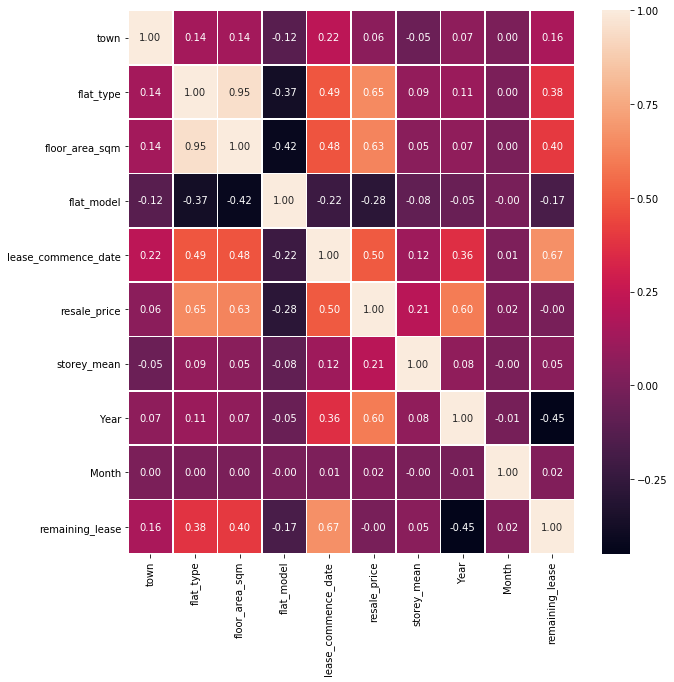

In [21]:
# plotting a correlational heatmap
f,ax = plt.subplots(figsize = (10,10))
sns.heatmap(df_temp.corr(),annot=True,linewidths=0.7,fmt='.2f',ax=ax)
plt.show()

From the heatmap, it is evident that there is a strong correlation (greater or equal to 0.5) for flat type, floor_area_sqm, lease commence date, and year with the resale price of the transaction. It is reasonable in real-life that the type of the flat is important, where the value of the flat can vary dependent on the number of rooms, for example. On a similar note, it also makes sense that the size of the flat is also important. Lease commence date shares a high correlation with the resale price because it can signify the age of the building. Usually, newer and more recent buildings tend to be more expensive. It was surprising to see how town was very poorly correlated to resale price, which is around 0.06. The same can be said about the month of the transaction, which does not denote significant correlation with the resale price.

#### Preprocessing Summary
The pre-processing approach consisted of first identifying which variables are categorical in nature, then checking for its unique values for any errors or variations. From this process, a minor adjustment to the multi-generation was made for the type of flat variable. In this way, all the labels were distinct and unique from each other to a significant extent for that column. Next, the storey range only differed by 3 or 5, however a few were overlapping and there was no simple solution to relabel the values without losing some of the distinctive information. As such, the average of the ends of the ranges were taken. In this way, it still captures the most essential information of the original data. Lastly, the flat model were configured to be all upper case. Arranging the labels into more similar groups were also considered, but was not pursed because each label can still be considered distinct enough to be different from one and another. In additional, some final touches were added to the data. On one hand, the time column was split into month and year of the transaction. On the other hand, the remaining lease column was added back by correctly calculating the remaining term (explained in the code block above).

### Drawing additional data for inflation rate
Additional data about Singapore's CPI was drawn from the department of statistics singapore, which is an official singapore government agency website (singstat.gov.sg). Although there were a lot of other sources available to derive the data, it is important to use credible sources. CPI is useful to derive the inflation rate, which can be used to recalculate the nominal prices of the resale value adjusted by inflation.

In [22]:
# CPI index for inflation rate
cpi.head()

,Time,All Items
0,1990 Jan,3.9
1,1990 Feb,3.9
2,1990 Mar,3.7
3,1990 Apr,3.7
4,1990 May,3.2


In [23]:
# checking for any missing values
print(cpi.isnull().mean()*100)

Time         0.0
All Items    0.0
dtype: float64


In [24]:
# splitting the time column into month and year
cpi['Year'] = cpi['Time'].apply(lambda x: x.split(' ')[1])
cpi['Month'] = cpi['Time'].apply(lambda x: x.split(' ')[2])
cpi.head()

,Time,All Items,Year,Month
0,1990 Jan,3.9,1990,Jan
1,1990 Feb,3.9,1990,Feb
2,1990 Mar,3.7,1990,Mar
3,1990 Apr,3.7,1990,Apr
4,1990 May,3.2,1990,May


In [25]:
# converting abbreviated month values to corresponding month number
mo_to_num = {mo: num for num, mo in enumerate(calendar.month_abbr) if num}
cpi['Month'] = cpi['Month'].apply(lambda x: mo_to_num[str(x)])
cpi['Month'] = pd.to_numeric(cpi['Month'])
cpi['Year'] = pd.to_numeric(cpi['Year'])
cpi = cpi.drop(['Time'],axis=1)

cpi.head()

,All Items,Year,Month
0,3.9,1990,1
1,3.9,1990,2
2,3.7,1990,3
3,3.7,1990,4
4,3.2,1990,5


In [26]:
cpi.dtypes

All Items    float64
Year           int64
Month          int64
dtype: object

In [27]:
# merging the master data with the CPI data on two primary keys
df_adj = pd.merge(df, cpi,  how='left', left_on=['Year','Month'], right_on = ['Year','Month'])
df_adj.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,storey_mean,Year,Month,remaining_lease,All Items
0,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,11,1990,1,86,3.9
1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,5,1990,1,86,3.9
2,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,11,1990,1,86,3.9
3,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,8,1990,1,86,3.9
4,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,5,1990,1,85,3.9


In [28]:
# adjusting the nominal resale price by inflation rate
df_adj['resale_price'] = df_adj['resale_price'] * ((100-df_adj['All Items'])/100)
df_adj = df_adj.drop(['All Items'],axis=1)
df_adj.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,storey_mean,Year,Month,remaining_lease
0,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8649.0,11,1990,1,86
1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,5766.0,5,1990,1,86
2,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,7688.0,11,1990,1,86
3,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,5766.0,8,1990,1,86
4,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,45359.2,5,1990,1,85


### Drawing additional data for property information
Additional data about Singapore's HDB property information was drawn from the same website that contained the resale transaction data (data.gov.sg). Depending on the property (prescribed based on block number and street address), it features information on the year that the construction completed, the type of building, max number of floors, and which type of flat was sold or rented. As such, this data greatly added more specific information about the specific properties.

In [29]:
prop_info.head()

,blk_no,street,max_floor_lvl,year_completed,residential,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,...,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental
0,1,BEACH RD,16,1970,Y,Y,N,N,N,N,...,138,1,2,0,0,0,0,0,0,0
1,1,BEDOK STH AVE 1,14,1975,Y,N,N,Y,N,N,...,204,0,2,0,0,0,0,0,0,0
2,1,CANTONMENT RD,2,2010,N,Y,N,N,N,N,...,0,0,0,0,0,0,0,0,0,0
3,1,CHAI CHEE RD,15,1982,Y,N,N,N,N,N,...,0,10,92,0,0,0,0,0,0,0
4,1,CHANGI VILLAGE RD,4,1975,Y,Y,N,N,N,N,...,54,0,1,0,0,0,0,0,0,0


In [30]:
# checking for any missing values
print(prop_info.isnull().mean()*100)

blk_no                   0.0
street                   0.0
max_floor_lvl            0.0
year_completed           0.0
residential              0.0
commercial               0.0
market_hawker            0.0
miscellaneous            0.0
multistorey_carpark      0.0
precinct_pavilion        0.0
bldg_contract_town       0.0
total_dwelling_units     0.0
1room_sold               0.0
2room_sold               0.0
3room_sold               0.0
4room_sold               0.0
5room_sold               0.0
exec_sold                0.0
multigen_sold            0.0
studio_apartment_sold    0.0
1room_rental             0.0
2room_rental             0.0
3room_rental             0.0
other_room_rental        0.0
dtype: float64


In [31]:
# creating a custom column to add the total number of rooms sold for any given property
prop_info['total_rooms_in_use'] = prop_info['1room_sold'] + prop_info['2room_sold'] + prop_info['3room_sold'] + prop_info['4room_sold'] + prop_info['5room_sold'] + prop_info['exec_sold'] + prop_info['multigen_sold'] + prop_info['studio_apartment_sold'] + prop_info['1room_rental'] + prop_info['2room_rental'] + prop_info['3room_rental'] + prop_info['other_room_rental']
prop_info.head()

,blk_no,street,max_floor_lvl,year_completed,residential,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,...,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,total_rooms_in_use
0,1,BEACH RD,16,1970,Y,Y,N,N,N,N,...,1,2,0,0,0,0,0,0,0,142
1,1,BEDOK STH AVE 1,14,1975,Y,N,N,Y,N,N,...,0,2,0,0,0,0,0,0,0,206
2,1,CANTONMENT RD,2,2010,N,Y,N,N,N,N,...,0,0,0,0,0,0,0,0,0,0
3,1,CHAI CHEE RD,15,1982,Y,N,N,N,N,N,...,10,92,0,0,0,0,0,0,0,102
4,1,CHANGI VILLAGE RD,4,1975,Y,Y,N,N,N,N,...,0,1,0,0,0,0,0,0,0,55


In [32]:
# editing the dataframe to only hold variables of interest
prop_info = prop_info[['blk_no','street','max_floor_lvl','year_completed','total_dwelling_units','total_rooms_in_use']]
prop_info.head()

,blk_no,street,max_floor_lvl,year_completed,total_dwelling_units,total_rooms_in_use
0,1,BEACH RD,16,1970,142,142
1,1,BEDOK STH AVE 1,14,1975,206,206
2,1,CANTONMENT RD,2,2010,0,0
3,1,CHAI CHEE RD,15,1982,102,102
4,1,CHANGI VILLAGE RD,4,1975,55,55


In [33]:
# merging the master data with the property information data on two primary keys
df_adj2 = pd.merge(df_adj, prop_info,  how='left', left_on = ['block','street_name'], right_on=['blk_no','street'])
df_adj2.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,storey_mean,Year,Month,remaining_lease,blk_no,street,max_floor_lvl,year_completed,total_dwelling_units,total_rooms_in_use
0,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8649.0,11,1990,1,86,NaN,NaN,NaN,NaN,NaN,NaN
1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,5766.0,5,1990,1,86,NaN,NaN,NaN,NaN,NaN,NaN
2,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,7688.0,11,1990,1,86,NaN,NaN,NaN,NaN,NaN,NaN
3,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,5766.0,8,1990,1,86,NaN,NaN,NaN,NaN,NaN,NaN
4,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,45359.2,5,1990,1,85,216,ANG MO KIO AVE 1,10.0,1975.0,144.0,144.0


In [34]:
# checking for any missing values
print(df_adj2.isnull().mean()*100)

town                    0.0000
flat_type               0.0000
block                   0.0000
street_name             0.0000
storey_range            0.0000
floor_area_sqm          0.0000
flat_model              0.0000
lease_commence_date     0.0000
resale_price            0.0000
storey_mean             0.0000
Year                    0.0000
Month                   0.0000
remaining_lease         0.0000
blk_no                  1.5948
street                  1.5948
max_floor_lvl           1.5948
year_completed          1.5948
total_dwelling_units    1.5948
total_rooms_in_use      1.5948
dtype: float64


In [35]:
# creating temp dataframe
df_temp = df_adj2.copy()
df_temp['town']=LabelEncoder().fit_transform(df_temp['town'])
df_temp['flat_type']=LabelEncoder().fit_transform(df_temp['flat_type'])
df_temp['flat_model']=LabelEncoder().fit_transform(df_temp['flat_model'])
df_temp.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,storey_mean,Year,Month,remaining_lease,blk_no,street,max_floor_lvl,year_completed,total_dwelling_units,total_rooms_in_use
0,0,0,309,ANG MO KIO AVE 1,10 TO 12,31.0,4,1977,8649.0,11,1990,1,86,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,309,ANG MO KIO AVE 1,04 TO 06,31.0,4,1977,5766.0,5,1990,1,86,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,309,ANG MO KIO AVE 1,10 TO 12,31.0,4,1977,7688.0,11,1990,1,86,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,309,ANG MO KIO AVE 1,07 TO 09,31.0,4,1977,5766.0,8,1990,1,86,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,216,ANG MO KIO AVE 1,04 TO 06,73.0,11,1976,45359.2,5,1990,1,85,216,ANG MO KIO AVE 1,10.0,1975.0,144.0,144.0


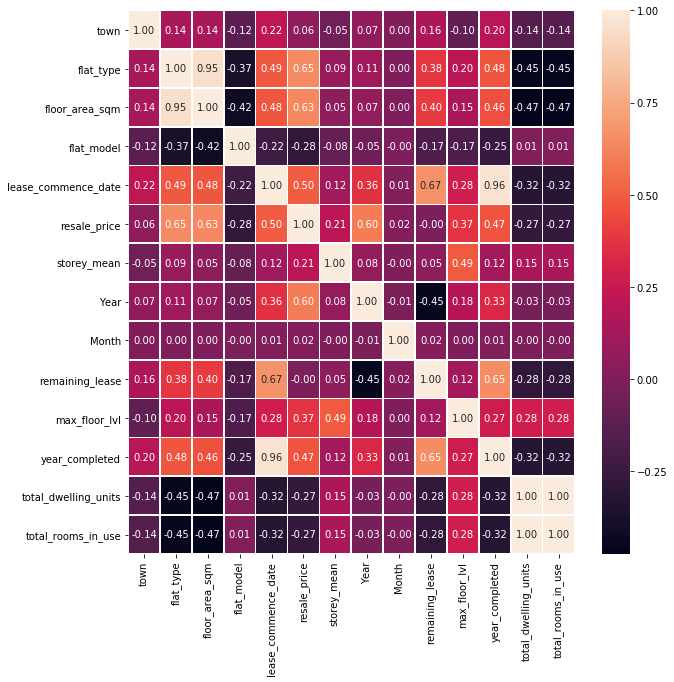

In [36]:
f,ax = plt.subplots(figsize = (10,10))
sns.heatmap(df_temp.corr(),annot=True,linewidths=0.7,fmt='.2f',ax=ax)
plt.show()

Another heatmap was necessary to determine the correlation for the new variables. From the results, both the number of floors and the year completed seem to share a high correlation with the target variable of interest. This is not surprising as taller and more recently built buildings are usually more expensive. Even though the other two variables shared less correlation, they are still significant enough to make sense of it in terms of context. Their negative correlation indicate that the higher the number of units, the less expensive the resale price of the associated HDB property. For the number of dwelling units in the apartment, its negative correlation makes sense because the original intention of the HDB flats were to provide affordable housing to as many people as possible. As such, I can imagine cheaper properties usually priortize the number of units. The same logic can be applied to the total rooms in use. Before moving on to the next section, there are four variables which indicate an issue of severe multicollinearity due to its strong correlation. This will be further explained in the modelling section.

### Data Exploration

Text(0, 0.5, 'Resale Price $')

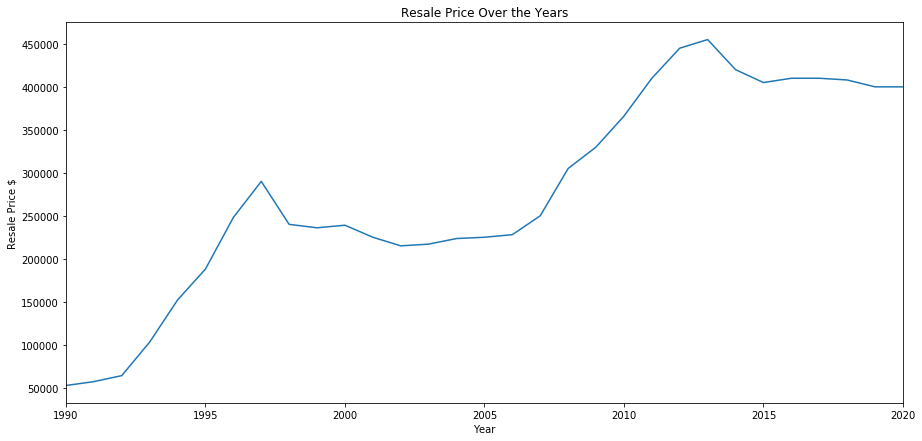

In [37]:
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['Year'],as_index=True).median()['resale_price'].plot(ax=ax)
ax.set_title("Resale Price Over the Years")
ax.set_xlabel("Year")
ax.set_ylabel("Resale Price $")

For a quick summary, the median resale price based on year was plotted to see how it changed over the years. There are two obvious peaks in 1997 and 2013. However, they are both followed by a significant drop. For the purpose of making sense of this trend, qualitative knowledge was research, in addition to relying on the quantitative data displayed above. The first drop can be explained by the economic recession. However, the second drop occuring after the 2013 peak was, in fact, due to specific measures enfroced by the government for the public housing market.

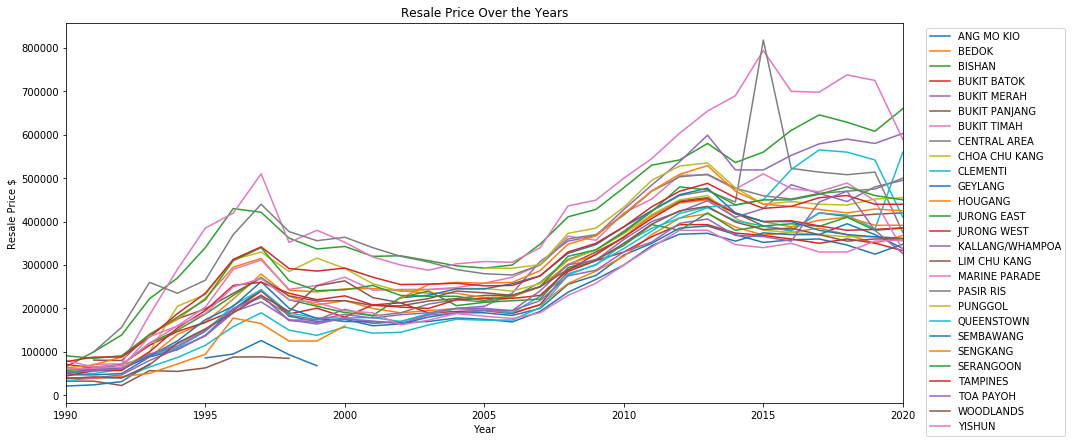

In [38]:
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['Year','town'],as_index=True).median()['resale_price'].unstack().plot(ax=ax)
ax.set_title("Resale Price Over the Years")
ax.set_xlabel("Year")
ax.set_ylabel("Resale Price $")
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1))

As you can see, the median resale price seems to be consistently different between town over the years. However, when examinely closely, there are, in fact, a lot of fluctations and cross overs between towns. However, the most expensive areas, such as Bukit Timah, Bishan, Central Area, etc. are still consistently at the top for majority of the years.

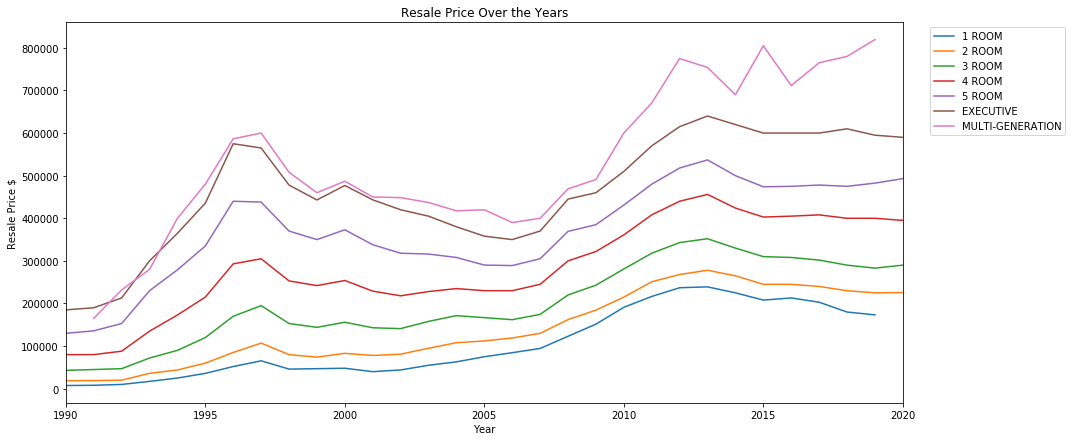

In [39]:
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['Year','flat_type'],as_index=True).median()['resale_price'].unstack().plot(ax=ax)
ax.set_title("Resale Price Over the Years")
ax.set_xlabel("Year")
ax.set_ylabel("Resale Price $")
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1))

It is evident that the trend by flat type is more clearly defined in comparison to town location. For example, one can see how multi-generation flat types are consistently the most expensive for majority of the years compared to other types. Therefore, there is a clear gap between the different types of flats. This is further reinforced by the fact that flat type has higher correlation than town, as demonstrated by the correlation heatmap earlier.

### Modeling the data

In [40]:
# listing only variables of interest
column_names = ['Month','Year','town','flat_type','storey_mean','flat_model','lease_commence_date','max_floor_lvl','total_dwelling_units','total_rooms_in_use','resale_price']

From the column names, it is important to point out that floor_area_sqm and year_completed have been left out. This is because of the issue of multicollinearity. As seen from the heatmap, floor_area_sqm has a high correlation with flat_type of 0.95. Simiarly, year_completed also has a high correlation of 0.96 with lease_commence date. This makes sense in real life terms because the area of the floor can be significantly depend on the type of the flat. Moreover, it also makes sense that the lease will commence soon after the construction of the building has completed.

Although multicollinearity is not really an issue for prediction purposes, it becomes a problem for casual inference. It does not really affect the prediction, as one variable is not doing more than the other in terms of predictive power, when both are highly correlated to each other. However, this becomes a problem when one wants to find out which variable is actually predicting when implementing both variables. For the purpose of this project, the two variabels were left out, and they were chosen instead of the other two because of their slighly higher correlation score in relation to the resale price.

In [41]:
# making the final dataframe based on the selected variables
df_final = df_adj2[column_names]
df_final = df_final.dropna()
df_final.head()

,Month,Year,town,flat_type,storey_mean,flat_model,lease_commence_date,max_floor_lvl,total_dwelling_units,total_rooms_in_use,resale_price
4,1,1990,ANG MO KIO,3 ROOM,5,NEW GENERATION,1976,10.0,144.0,144.0,45359.2
5,1,1990,ANG MO KIO,3 ROOM,2,NEW GENERATION,1977,10.0,215.0,215.0,44206.0
6,1,1990,ANG MO KIO,3 ROOM,8,NEW GENERATION,1977,10.0,129.0,129.0,40362.0
7,1,1990,ANG MO KIO,3 ROOM,11,NEW GENERATION,1977,12.0,153.0,153.0,36518.0
8,1,1990,ANG MO KIO,3 ROOM,5,NEW GENERATION,1977,12.0,153.0,153.0,38440.0


In [42]:
# encoding all categorical or descriptive variables
df_final['town']=LabelEncoder().fit_transform(df_final['town'])
df_final['flat_type']=LabelEncoder().fit_transform(df_final['flat_type'])
df_final['flat_model']=LabelEncoder().fit_transform(df_final['flat_model'])
df_final.head()

,Month,Year,town,flat_type,storey_mean,flat_model,lease_commence_date,max_floor_lvl,total_dwelling_units,total_rooms_in_use,resale_price
4,1,1990,0,2,5,11,1976,10.0,144.0,144.0,45359.2
5,1,1990,0,2,2,11,1977,10.0,215.0,215.0,44206.0
6,1,1990,0,2,8,11,1977,10.0,129.0,129.0,40362.0
7,1,1990,0,2,11,11,1977,12.0,153.0,153.0,36518.0
8,1,1990,0,2,5,11,1977,12.0,153.0,153.0,38440.0


In [43]:
# splitting the data into train set
train = df_final.loc[(df_final['Year'] != 2019) & (df_final['Year'] != 2020)]
train.Year.unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype=int64)

In [44]:
# splitting the data into test set
test = df_final.loc[df_final['Year'].isin([2019,2020])]
test.Year.unique()

array([2019, 2020], dtype=int64)

In [45]:
# splitting the data into target and predictor variables
X_train = train.drop(['resale_price'],axis=1)
X_test = test.drop(['resale_price'],axis=1)
y_train = train['resale_price']
y_test = test['resale_price']

In [46]:
# function to evaluate regression models
def model_eval_metrics(y_true, y_pred):
    mse_eval = mean_squared_error(y_true, y_pred)
    rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
    mae_eval = mean_absolute_error(y_true, y_pred)
    r2_eval = r2_score(y_true, y_pred)
    metricdata = {'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
    finalmetricdata = pd.DataFrame.from_dict(metricdata)
    return finalmetricdata

In [47]:
#alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
#grid = GridSearchCV(estimator=Lasso(max_iter=100000), param_grid=dict(alpha=alphas))
#grid.fit(X_train, y_train)
#print("Best mean cross-validation score: {:.3f}".format(grid.best_score_))
#print("Best parameters: {}".format(grid.best_estimator_.alpha))
#print("Test set score: {:.3f}".format(grid.score(X_test, y_test)))

In [49]:
# lasso regression code block
lasso = Lasso(alpha=0.1, max_iter=100000).fit(X_train, y_train)
y_pred = lasso.predict(X_test)
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))
print("Lasso coefficients: {}".format(lasso.coef_))
modelevalobject=model_eval_metrics(y_test,y_pred)
modelevalobject

Number of features used: 10
Lasso coefficients: [ 1.01680618e+03  1.00099747e+04 -7.45401745e+02  7.95767901e+04
  1.66245390e+03 -1.42577333e+03 -4.35204138e+02  4.76727829e+03
 -1.99063631e+02 -8.32650368e-15]


,mse,rmse,mae,r2
0,1.115672e+10,105625.38679,85009.420936,0.520854


In [ ]:
#rf = RandomForestRegressor()
#param_grid = { 
#            "n_estimators"      : [10,20,30],
#            "min_samples_split" : [2,4,8]
#            }
#grid = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1, cv=5)
#grid_result = grid.fit(X_train, y_train)
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

In [62]:
rf = RandomForestRegressor(n_estimators=30, min_samples_split=8).fit(X_train,y_train)
y_pred = rf.predict(X_test)
print("Feature importance: {}".format(rf.feature_importances_))
modelevalobject=model_eval_metrics(y_test,y_pred)
modelevalobject

Feature importance: [0.00747463 0.45920223 0.04747662 0.38414958 0.00596329 0.01486581
 0.02065491 0.04818939 0.00596268 0.00606088]


,mse,rmse,mae,r2
0,1.452334e+09,38109.49594,26773.100092,0.937627


In [54]:
#param_grid = {
#    'num_leaves': [20, 30, 40]
#    }

#lgbmr = lgb.LGBMRegressor(objective='regression', num_leaves=20, learning_rate=0.1, n_estimators=500)
#grid = GridSearchCV(estimator=lgbmr,param_grid=param_grid)
#grid_result = grid.fit(X_train, y_train, early_stopping_rounds=45, eval_metric='rmse', eval_set=(X_test, y_test), verbose=False)
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

In [60]:
lgbmr = lgb.LGBMRegressor(objective='regression', num_leaves=30, max_depth=5, learning_rate=0.1, n_estimators=450)
lgbmr.fit(X_train, y_train, early_stopping_rounds=45, eval_metric='rmse', eval_set=(X_test, y_test), verbose=False)
y_pred = lgbmr.predict(X_test)
print("Feature importance: {}".format(lgbmr.feature_importances_))
modelevalobject=model_eval_metrics(y_test,y_pred)
modelevalobject

Feature importance: [ 517 2957 2695 1166  352  847 1798 1196 1179    0]


,mse,rmse,mae,r2
0,1.785348e+09,42253.373951,31036.917611,0.923325


#### Model Summary

Lasso: Among the linear regression models, this was chosen due to its shrinkage feature, which allows for automatic variable selection from its added penalty. Using GridSearchCV, the alpha parameter was tuned. However, it still ranked the lowest among the three models.

Random Forest Regressor & LGBM Regressor: Some hypertuning parameters were conducted. However, due to the requirement of significant time to compute the optimal paramters, all of the relevant parameters could not be tested. Regardless, both of their performance are very impressive. On one hand, LGBM is based on shallow tress with high bias and low variance, while random forest is based on fully grown trees characterized by low bias and high variance. As such, random forest is generally more robust, and serve as a good baseline model for now. However, GMBs, like LGBM, will most likely outperform when its relevant parameters are further tuned.

In brief, due to the time restriction of this project, the best available model is the random forest regression with an r2 of 0.937627, and, most importantly, a rmse score of 38109.49594 and a mae score of 26773.100092. In other words, the model can explain 93.4% of the variation in the target variable of resale price centered around its mean, and that the model is able to predict the resale price that are only plus or minus 26.7K off on average.

Lasso Feature Importance: [ 1.01680618e+03  1.00099747e+04 -7.45401745e+02  7.95767901e+04
  1.66245390e+03 -1.42577333e+03 -4.35204138e+02  4.76727829e+03
 -1.99063631e+02 -8.32650368e-15]
 
Random Forest Feature Importance: [0.00747463 0.45920223 0.04747662 0.38414958 0.00596329 0.01486581
 0.02065491 0.04818939 0.00596268 0.00606088]

LGBM Feature Importance: [ 517 2957 2695 1166  352  847 1798 1196 1179    0]

When looking at the feature importance, there are some relative agreements across the models. Significant weights seem to be given to the year and flat type, which agree with the previous correlational heatmap. For example, using the best model feature importances for random forest, year and flat type have the largest impact on the resale price of more than 38% at least.

Overall, both the LGBM and Random Forest Regressor models performed well. If more time was given, the parameters of the LGBM model will be more finely tuned, which would ultimately outperform the random forest model. In the end, this was a very interesting and intriguing exercise.